Import OpenCV detector.

In [7]:
from menpodetect.opencv import load_opencv_frontal_face_detector

face_detector = load_opencv_frontal_face_detector()

Train landmarks fitter.

*This and other comments are same as in Dlib version*

In [16]:
path_to_lfpw = 'C:\\_personal\\menpo\\lfpw\\'

import menpo.io as mio

training_images = []
# load landmarked images
for i in mio.import_images(path_to_lfpw + 'trainset/*', verbose=True):
    # crop image
    i.crop_to_landmarks_proportion(0.1)
    # convert it to greyscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')
    # append it to the list
    training_images.append(i)

    
from menpofit.clm import CLMBuilder

clm = CLMBuilder().build(training_images, verbose=True)

from menpofit.clm import GradientDescentCLMFitter

fitter = GradientDescentCLMFitter(clm, n_shape=[3, 6, 12])



Importing assets: [==========] 100% (811/811) - done.                           
- Normalizing images size: Done
- Computing top-level feature space: 100% - done.                               
- Building model for each of the 3 pyramid levels
  - Level 1: Done
  - Level 2: Done
  - Level 3: Done


In [17]:
from os import walk
from os.path import join

from menpo.io import import_image


base_path = 'C:\\_personal\\menpo\\images'

files = []
for (dirpath, dirnames, filenames) in walk(base_path):
    files.extend(filenames)
    break

test_images = []
for each in files:
    file_path = join(base_path, each)
    print file_path
    test_images.append(import_image(join(base_path, file_path)))

C:\_personal\menpo\images\image_0001.png
C:\_personal\menpo\images\image_0002.png
C:\_personal\menpo\images\image_0003.JPG
C:\_personal\menpo\images\image_0004.JPG
C:\_personal\menpo\images\image_0005.JPG
C:\_personal\menpo\images\image_0006.JPG
C:\_personal\menpo\images\image_0007.JPG
C:\_personal\menpo\images\IMG_20150630_184825.jpg
C:\_personal\menpo\images\IMG_20150816_001532.jpg
C:\_personal\menpo\images\IMG_20150914_155618.jpg


In [18]:
%matplotlib inline

In [19]:
face_found = []
face_not_found = []
for pic in test_images:
    face_detector(pic)
    if pic.n_landmark_groups > 0:
        face_found.append(pic)
    else:
        face_not_found.append(pic)

print 'Found:', len(face_found)
print 'Not found:', len(face_not_found)

Found: 7
Not found: 3


In [20]:
prepare = []
for pic in face_found:
    pic = pic.crop_to_landmarks_proportion(0.1)
    if pic.n_channels > 1:
        pic = pic.as_greyscale(mode='luminosity')
    prepare.append(pic)


face_sq = [pic.landmarks['opencv_0'].lms for pic in prepare]


import math

ref_shape = clm.reference_shape

def calc_diag(bb):
    diag = abs(bb.points[2] - bb.points[0])
    return math.sqrt(diag[0] ** 2 + diag[1] **2)

shape_diag = calc_diag(ref_shape.bounding_box())

face_diag = [calc_diag(sq.bounding_box()) for sq in face_sq]

In [80]:
from menpo.transform import Translation
from menpo.transform import UniformScale

for i, pic in enumerate(prepare):
    rescale = UniformScale(face_diag[i] / (shape_diag * 1.2), 2).apply(ref_shape)
    #move = Translation(face_sq[i].points[0] - (ref_shape.bounding_box().points[0]) * 1.0).apply(rescale)
    move = Translation(face_sq[i].points[0] - (rescale.bounding_box().points[0]) * 0.8).apply(rescale)
    pic.landmarks['a1'] = move

a = face_sq[0]

In [64]:
a.points

array([[  21.,   21.],
       [ 228.,   21.],
       [ 228.,  228.],
       [  21.,  228.]])

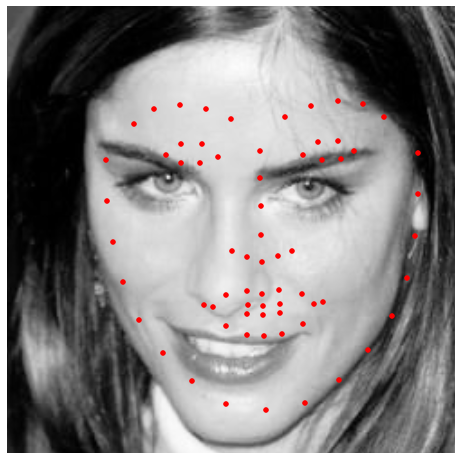

In [81]:
visualize_images(prepare)

In [82]:
fr = [fitter.fit(pic, pic.landmarks['a1'].lms) for pic in prepare]

In [83]:
res = [pic.fitted_image for pic in fr]

In [84]:
from menpo.landmark.labels import labeller, ibug_face_68

for pic in res:
    labeller(pic, 'final', ibug_face_68)

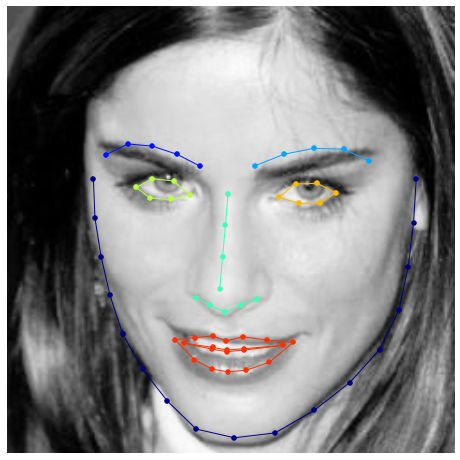

In [85]:
from menpo.visualize import visualize_images

visualize_images(res)